In [1]:
import pandas as pd
import numpy as np
import ROOT as R
#R.enableJSVis()
R.ROOT.EnableImplicitMT()

c1=R.TCanvas('c1','c1',900,700)

t=R.TLatex()
t.SetTextSize(0.04)

graphs={}

Welcome to JupyROOT 6.20/04


In [2]:
#few functions definition

logit=R.TF1("logit","[0]/(1+TMath::Exp(-[1]*(x-[2])))",0,100)
logit.SetParameter(0,100)
logit.SetParLimits(0,0,10000)
logit.SetParameter(1,3)
logit.SetParLimits(1,0.,50.)
logit.SetParameter(2,5)
logit.SetParLimits(2,0.,200.)

f=R.TF1("ff","TMath::Exp((x+[0])/[1])",0,100)
f.SetParameter(0,13)
f.SetParLimits(0,-100,100)
f.SetParameter(1,4.5)
f.SetParLimits(1,1.,6.)

dgompertz= R.TF1('dgompertz','[0]*[1]*[2]*TMath::Exp(-[1]*TMath::Exp(-[2]*(x-[3]))-[2]*(x-[3]))',-100,100)
dgompertz.SetParameter(0,30000)
dgompertz.SetParLimits(0,0,100000)
dgompertz.SetParameter(2,0.1)
dgompertz.SetParLimits(2,0.1,0.3)
dgompertz.SetParameter(1,5)
dgompertz.SetParLimits(1,1,10)
dgompertz.SetParameter(3,40)
dgompertz.SetParLimits(3,35,50)

covidTotal=R.TF1('covidTotal','[0]*[1]*[2]*TMath::Exp(-[1]*TMath::Exp(-[2]*(x-[3]))-[2]*(x-[3]))+[4]*(1+TMath::Erf((x-[5])/([6]*TMath::Sqrt(x))))',0,100)
covidTotal.SetParameter(0,30000)
covidTotal.SetParLimits(0,0,100000)
covidTotal.SetParameter(2,0.1)
covidTotal.SetParLimits(2,0.01,0.3)
covidTotal.SetParameter(1,5)
covidTotal.SetParLimits(1,1.,10.)
covidTotal.SetParameter(3,40)
covidTotal.SetParLimits(3,35,100)
covidTotal.SetParLimits(4,0,10)
covidTotal.SetParameter(5,35)
covidTotal.SetParLimits(5,30,40)
covidTotal.SetParameter(6,0.5)
covidTotal.SetParLimits(6,0.05,1.)

cdeaths=R.TF1('cdeaths','[0]*(1+TMath::Erf((x-[1])/([2]*TMath::Sqrt(x))))',0,100)
cdeaths.SetParameter(0,1)
cdeaths.SetParameter(1,35)
cdeaths.SetParameter(2,0.5)

In [74]:
def getHisto(graph):
    n=graph.GetN()
    minX=R.TMath.MinElement(n,graph.GetX())
    maxX=R.TMath.MaxElement(n,graph.GetX())
    binSize=(maxX-minX)/n #assume uniform spacing
    h=R.TH1F(graph.GetName()+'_histo',graph.GetName()+'_histo',n+1,minX-binSize,maxX+binSize)
    h.SetBinContent(0,0)
    for i in range(n):
        x,y=R.Double(0),R.Double(0)
        graph.GetPoint(i,x,y)
        if (y>0):
            h.SetBinContent(i+1,y)
        else:
            h.SetBinContent(i+1,0)
    return h

def getInterpolatedHisto(graph,histo):
    n=graph.GetN()
    n1=histo.GetNbinsX()
    h=histo.Clone(graph.GetName()+'_histo')
    h.SetBinContent(0,0)
    for i in range(n1):
        x=histo.GetXaxis().GetBinCenter(i+1)
        y=graph.Eval(x)
        if (y>0):
            h.SetBinContent(i+1,y)
        else:
            h.SetBinContent(i+1,0)
    return h

def addGraphs(graphs):
    if len(graphs)<2:
        return
    
#get minimum size
    n=graphs[0].GetN()
    for g in graphs:
        if (g.GetN()<n):
            n=g.GetN()

    g=R.TGraphErrors()
    for i in range(n):
        x1,y1=R.Double(0),R.Double(0)
        graphs[0].GetPoint(i,x1,y1)
        g.SetPoint(i,x1,y1)
        g.SetPointError(i,graphs[0].GetErrorX(i),graphs[0].GetErrorY(i))

    for ig,g1 in enumerate(graphs):
        if ig==0:
            continue
        for i in range(n):
            x1,y1=R.Double(0),R.Double(0)
            g1.GetPoint(i,x1,y1)
            x,y=R.Double(0),R.Double(0)
            g.GetPoint(i,x,y)
            if (x1 != x):
                print('x1 != x. This should not happen!')
            g.SetPoint(i,x,y+y1)
            err=R.TMath.Sqrt(g.GetErrorY(i)**2+g1.GetErrorY(i)**2)
            g.SetPointError(i,g.GetErrorX(i),err)
            
    return g

def addFunctions(functions,xMin,xMax):
    xP=np.linspace(xMin,xMax,1000)
    g=R.TGraphErrors()
    for ix,x in enumerate(xP):
        g.SetPoint(ix,x,0)
        for f in functions:
            x,y=R.Double(0),R.Double(0)
            g.GetPoint(ix,x,y)
            g.SetPoint(ix,x,y+f.Eval(x))
    g.SetLineWidth(2)
    g.SetLineColor(R.kRed)
    return g

def rebinGraph(g,r,assignError):
    n=g.GetN()
    g1=R.TGraphErrors()
    g1.SetName(g.GetName()+'_rebin%d'%r)
    ibin=0
    average_Y=0
    average_X=0
    sumw2=0
    nbin=0
    for i in range(n):
        ibin+=1
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        average_X+=x
        average_Y+=y
        erry=g.GetErrorY(i)
        if (erry>0):
            w2=1/(erry**2)
        else:
            w2=0.
        sumw2+=w2
        if (ibin>=r or i==n-1):
            average_Y=average_Y/ibin
            average_X=average_X/ibin
            if (sumw2>0):
                err_Y=R.TMath.Sqrt(1/sumw2)
            else:
                err_Y=0.
            err_X=float(ibin)/2.
            g1.SetPoint(nbin,average_X,average_Y)
            if (assignError):
                g1.SetPointError(nbin,err_X,err_Y)
            else:
                g1.SetPointError(nbin,0,0)
            nbin+=1
            ibin=0
            average_Y=0
            average_X=0
            sumw2=0
    return g1

def errorGraphBand(g,g2):
    n=g.GetN()
    g1=R.TGraphAsymmErrors(n)
    g1.SetName(g.GetName()+'_%s_error'%g2.GetName())
    ibin=0
    for i in range(n):
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        x1,y1=R.Double(0),R.Double(0)
        g2.GetPoint(i,x1,y1)
        #assign half difference one sided as error
        g1.SetPoint(i,x,y)
        g1.SetPointError(i,0.5,0.5,0.,(y1-y)*0.5)
    return g1

def integralGraph(g,firstPoint,lastPoint=-1):
    if (lastPoint==-1):
        lastPoint=g.GetN()
    integral=0
    error=0
    for i in range(firstPoint,lastPoint):
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        integral+=y
        error+=g.GetErrorY(i)*g.GetErrorY(i)
    return [integral,R.TMath.Sqrt(error)]

In [4]:
smooth=R.TGraphSmooth()
smooth1=R.TGraphSmooth()

In [5]:
#Official data from http://www.epiprev.it/sites/default/files/SISMG_COVID19_28032020.pdf
urlByTown = 'mortalita_settimanale_per_citta.csv'
dfByTown = pd.read_csv(urlByTown)

urlByTownDaily = 'mortalita_giornaliera_per_citta.csv'
dfByTownDaily = pd.read_csv(urlByTownDaily)

urlByTownAgeWeekly = 'mortalita_settimanale_byAge.csv'
dfByTownAgeWeekly = pd.read_csv(urlByTownAgeWeekly)

In [6]:
urlIstat = '~/Downloads/comuni_settimana.csv'
dfIstat = pd.read_csv(urlIstat)
dfIstat.tail()

,REG,PROV,COD_PROVCOM,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,DATA_INIZIO_DIFF,SETTIMANA,CLASSE_DI_ETA,MASCHI_2015,...,FEMMINE_2017,FEMMINE_2018,FEMMINE_2019,FEMMINE_2020,TOTALE_2015,TOTALE_2016,TOTALE_2017,TOTALE_2018,TOTALE_2019,TOTALE_2020
87823,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,01/03-07/03,75 anni e più,2,...,1,0,1,1,2,2,2,0,2,2
87824,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,08/03-14/03,75 anni e più,2,...,1,0,2,0,3,0,1,0,2,2
87825,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,15/03-21/03,75 anni e più,0,...,0,0,0,1,1,1,0,0,0,1
87826,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,22/03-28/03,75 anni e più,1,...,0,3,0,0,1,1,1,3,0,1
87827,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,29/03-04/04,75 anni e più,0,...,0,0,1,0,0,0,0,0,1,1


In [7]:
dfByTown.tail()

,Town,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13
11,Roma,484,506,453,480,483,490,540,521.0,547.0
12,Bari,57,63,53,56,74,78,54,NaN,NaN
13,Potenza,7,12,8,12,16,8,18,NaN,NaN
14,Messina,53,48,65,56,50,49,61,NaN,NaN
15,Palermo,125,152,126,145,133,149,124,NaN,NaN


In [8]:
#Official data from Protezione Civile
urlByProvince = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
urlNational = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
urlByRegion = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'


dfByProvince = pd.read_csv(urlByProvince,na_filter = False)
dfNational = pd.read_csv(urlNational)
dfByRegion = pd.read_csv(urlByRegion)

lastDate=dfNational['data'][len(dfNational)-1]

#dfByProvince.head(5)
#dfNational.head(5)

print("Last data %s"%lastDate)

Last data 2020-04-26T17:00:00


In [9]:
df={}

provinces = np.unique(dfByTown['Town'])
for p in provinces:
    df[p]=dfByTown[dfByTown['Town']==p]
    df[p]=df[p].drop(columns=['Town'])
    df[p]=df[p].transpose()
    df[p].columns=['number_of_deaths']
    #df[p]=df[p].set_index('week')

dfDaily={}

provincesDaily = np.unique(dfByTownDaily['Town'])
for p in provincesDaily:
    dfDaily[p]=dfByTownDaily[dfByTownDaily['Town']==p]
    dfDaily[p]=dfDaily[p].drop(columns=['Town'])
    dfDaily[p]=dfDaily[p].transpose()
    dfDaily[p].columns=['number_of_deaths']
    dfDaily[p]['number_of_deaths']=dfDaily[p]['number_of_deaths'].astype(float)
    #print('---- %s ----'%p)
    #print(dfDaily[p].tail().to_string())

dfPCM={}

for p in provincesDaily:
    dfPCM[p]=dfByProvince[dfByProvince['denominazione_provincia']==p]

for p in np.unique(dfByRegion['denominazione_regione']):
    dfPCM[p]=dfByRegion[dfByRegion['denominazione_regione']==p]

population = pd.read_csv('italianPopulation.csv')
#population = population.set_index('Territory')
#population.colums=['population']


In [10]:
dfPCM['Piemonte'].tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
1230,2020-04-22T17:00:00,ITA,1,Piemonte,45.073274,7.680687,3213,273,3486,11636,15122,311,784,5058,2559,22739,111513,81176.0,NaN,NaN
1251,2020-04-23T17:00:00,ITA,1,Piemonte,45.073274,7.680687,3039,261,3300,11852,15152,30,401,5358,2630,23140,117970,84648.0,NaN,NaN
1272,2020-04-24T17:00:00,ITA,1,Piemonte,45.073274,7.680687,2918,257,3175,12216,15391,239,682,5732,2699,23822,125300,89392.0,NaN,NaN
1293,2020-04-25T17:00:00,ITA,1,Piemonte,45.073274,7.680687,2937,238,3175,12327,15502,111,604,6157,2767,24426,131107,93325.0,NaN,NaN
1314,2020-04-26T17:00:00,ITA,1,Piemonte,45.073274,7.680687,2866,214,3080,12439,15519,17,394,6478,2823,24820,135142,96977.0,NaN,NaN


In [11]:
print(population.to_string())

                 Territory  Population
0                    Italy    60359546
1               Nord ovest    16093286
2                      Sud    13957942
3                Centro(I)    12016009
4                 Nord est    11652827
5                Lombardia    10060574
6                    Isole     6639482
7                    Lazio     5879082
8                 Campania     5801692
9                  Sicilia     4999891
10                  Veneto     4905854
11          Emilia Romagna     4459477
12                Piemonte     4356406
13                    Roma     4342212
14                  Puglia     4029053
15                 Toscana     3729641
16                  Milano     3250315
17                  Napoli     3084890
18                  Torino     2259523
19                Calabria     1947131
20                Sardegna     1639591
21                 Liguria     1550640
22                  Marche     1525271
23                 Abruzzo     1311580
24                 Bresci

In [12]:
regions=np.unique(dfByRegion['denominazione_regione'])
print(regions)

['Abruzzo' 'Basilicata' 'Calabria' 'Campania' 'Emilia-Romagna'
 'Friuli Venezia Giulia' 'Lazio' 'Liguria' 'Lombardia' 'Marche' 'Molise'
 'P.A. Bolzano' 'P.A. Trento' 'Piemonte' 'Puglia' 'Sardegna' 'Sicilia'
 'Toscana' 'Umbria' "Valle d'Aosta" 'Veneto']


In [13]:
graphs={}

#"Brescia","Torino","Milano","Genova","Aosta","Bari","Bologna","Bolzano","Messina","Palermo","Perugia","Potenza","Roma","Trento","Venezia","Verona"
#regions=[
#    'Lombardia',
#    'Piemonte',
#    'Liguria',
#    'Veneto',
#    'Lazio',
#]

townRegion={
    'Brescia':'Lombardia',
    'Milano':'Lombardia',
    'Torino':'Piemonte',
    'Genova':'Liguria',
    'Firenze':'Toscana',
    'Padova':'Veneto',
    'Roma':'Lazio',
    'Bari':'Puglia',
    'Bologna':'Emilia-Romagna',
    'Messina':'Sicilia',
    'Palermo':'Sicilia',
    'Perugia':'Umbria',
    'Potenza':'Basilicata',
    'Venezia':'Veneto',
    'Aosta':"Valle d'Aosta",
    'Trento':"P.A. Trento",
    'Bolzano':"P.A. Bolzano",
    'Verona':'Veneto'
}

townPopulation={
    'Brescia':196670,
    'Milano':1.352E6,
    'Torino':886837,
    'Genova':583601,
    'Roma':2.873E6,
    'Firenze':382258,
    'Padova':209829,
    'Bari':324198,
    'Bologna':388367,
    'Messina':236962,
    'Palermo':673735,
    'Perugia':166676,
    'Potenza':67168,
    'Venezia':261905,
    'Aosta':34361,
    'Trento':117417,
    'Bolzano':106951,
    'Verona':922383,
}

deathRatio_65p=0.9 #Table1 https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_26-marzo%202020.pdf

keys=["deceduti","terapia_intensiva","totale_ospedalizzati","nuovi_positivi","dimessi_guariti"]

deathTime=7

for ip,p in enumerate(regions):
    pr=p.replace('-',' ')
    #if 
    #np=population.loc[pr,'Population']
    for ik,k in enumerate(keys):
        graphs['%s_%s'%(k,p)]=R.TGraphErrors()
        graphs['%s_%s'%(k,p)].SetName('%s_%s'%(k,p))
        for i,ni in enumerate(dfPCM[p][k]):
            graphs['%s_%s'%(k,p)].SetPoint(i,i,float(ni))
            graphs['%s_%s'%(k,p)].SetPointError(i,0,R.TMath.Sqrt(ni))

fracFixed={
    'Genova':0.3,
    'Torino':0.5,
    'Milano':0.2,
    'Brescia':0.2
}

#fracBrescia=241./225. #from official data for Brescia
fracBrescia=1.

for p in provincesDaily:
    #print(p)
    graphs['totale_casi_%s'%p]=R.TGraphErrors()
    graphs['totale_casi_%s'%p].SetName("infected_%s"%p)
    
    graphs['estimated_death_town_%s'%p]=R.TGraphErrors()
    graphs['estimated_death_town_%s'%p].SetName("estimated_death_town_%s"%p)

    pr=p.replace('-',' ')
    if (pr=='Aosta'):
        pr="Valled'Aosta"
    #print(p,pr,n.array(population[population['Territory']==pr]['Population'])[0])        
    pop=np.array(population[population['Territory']==pr]['Population'])[0]
    sumD=0
    fracPopulation=townPopulation[p]/pop
    for i,ni in enumerate(dfPCM[p]['totale_casi']):
        graphs['totale_casi_%s'%p].SetPoint(i,i+24,ni) #daily series here starts from 0
        graphs['totale_casi_%s'%p].SetPointError(i,0,R.TMath.Sqrt(ni))
        #print(ni)
        
        if (i>deathTime): #look in the past to estimate fraction of deaths... not ideal
            DD=dfPCM[townRegion[p]]['deceduti'].iloc[i]-dfPCM[townRegion[p]]['deceduti'].iloc[i-1]
            fracP=0.
            nP=0
            for ii in range(i-1-deathTime,i-deathTime+1):
                if (dfPCM[townRegion[p]]['totale_casi'].iloc[ii]>0):
                    fracP+=dfPCM[p]['totale_casi'].iloc[ii]/dfPCM[townRegion[p]]['totale_casi'].iloc[ii]
                    nP+=1
            if(nP>0):
                fracP=fracP/nP
            #fracP=fracFixed[p] #test fixed Fraction (no shape variation)
            D=dfPCM[townRegion[p]]['deceduti'].iloc[i]*fracP
            D1=dfPCM[townRegion[p]]['deceduti'].iloc[i-1]*fracP
            newD=D-D1
            ed=newD*fracPopulation
            if (p=='Brescia'):
                ed=ed*fracBrescia
            sumD+=ed
            graphs['estimated_death_town_%s'%p].SetPoint(i-8,i+23,ed)
    print(p,i+23,'%d %.1f %d %.2f %.2f %.1f'%(dfPCM[townRegion[p]]['deceduti'].iloc[i],sumD,DD,fracP,fracPopulation,ed))

Aosta 85 131 35.5 1 1.00 0.27 0.3
Bari 85 399 31.8 8 0.31 0.26 0.7
Bologna 85 3386 140.4 39 0.17 0.38 2.5
Bolzano 85 269 54.2 4 1.00 0.20 0.8
Brescia 85 13325 371.1 56 0.18 0.16 1.6
Firenze 85 778 76.8 18 0.31 0.38 2.1
Genova 85 1114 325.9 21 0.57 0.69 8.3
Messina 85 228 13.2 4 0.18 0.38 0.3
Milano 85 13325 959.2 56 0.24 0.42 5.6
Padova 85 1315 77.7 27 0.23 0.22 1.4
Palermo 85 228 19.4 4 0.15 0.54 0.3
Perugia 85 64 11.1 1 0.72 0.25 0.2
Potenza 85 25 2.8 0 0.49 0.18 0.0
Roma 85 389 191.2 2 0.71 0.66 0.9
Torino 85 2823 498.4 56 0.48 0.39 10.6
Trento 85 405 87.9 5 1.00 0.22 1.1
Venezia 85 1315 55.5 27 0.13 0.31 1.1
Verona 85 1315 272.1 27 0.25 1.00 6.7


In [14]:
# # of usable days in the last week according to Table1. Do we really need to scale last week??
lastWeekDays={
    'Aosta':5.,
    'Bolzano':5.,
    'Brescia':4.,
    'Torino':7.,
    'Milano':5.,
    'Genova':6.,
    'Bologna':6.,
    'Verona':5.,
    'Venezia':4.,
    'Roma':4.,
    'Civitavecchia':6.,
    'Bari':5.,
    'Potenza':6.,
    'Perugia':4.,
    'Messina':7.,
    'Palermo':4.
}

In [15]:
df['Roma'].tail()

,number_of_deaths
Week 9,483.0
Week 10,490.0
Week 11,540.0
Week 12,521.0
Week 13,547.0


In [16]:
#Fill Root TGraphErrors
for p in provinces:
    graphs['deceduti_%s'%p]=R.TGraphErrors()
    graphs['deceduti_%s'%p].SetName('deceduti_%s'%p)
                                    
    for i,ni in enumerate(df[p]['number_of_deaths']):
        scale=1.
        #if (i==len(df[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        #    if (scale>1.):
        #        print("Last week re-scaling %s %.2f"%(p,scale))
        graphs['deceduti_%s'%p].SetPoint(i,i+5,df[p]['number_of_deaths'][i]*scale)
        graphs['deceduti_%s'%p].SetPointError(i,0.5,R.TMath.Sqrt(df[p]['number_of_deaths'][i])*scale)
    graphs['deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['deceduti_%s'%p].SetMarkerStyle(25)
    graphs['deceduti_%s'%p].SetMarkerSize(1.3)
    #Temporary: using as baseline fit of February data
    fB=R.TF1('fB','[0]*(1-0.0023*7*(x-5))',0,100)
    graphs['deceduti_%s'%p].Fit('fB','RQB+','',5,8.5)

    graphs['eccesso_deceduti_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_%s'%p].SetName('eccesso_deceduti_%s'%p)
    for i,ni in enumerate(df[p]['number_of_deaths']):
        scale=1.
        #if (i==len(df[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        graphs['eccesso_deceduti_%s'%p].SetPoint(i,i+5,df[p]['number_of_deaths'][i]*scale-graphs['deceduti_%s'%p].GetFunction('fB').Eval(i+5))
        graphs['eccesso_deceduti_%s'%p].SetPointError(i,0,R.TMath.Sqrt(df[p]['number_of_deaths'][i])*scale)
    graphs['eccesso_deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerStyle(24)
    graphs['eccesso_deceduti_%s'%p].SetMarkerSize(0.9)
                                                                  

In [17]:
for p in provincesDaily:
    graphs['deceduti_giornalieri_%s'%p]=R.TGraphErrors()
    graphs['deceduti_giornalieri_%s'%p].SetName('deceduti_giornalieri_%s'%p)                               
    for i,ni in enumerate(dfDaily[p]['number_of_deaths']):
        if(pd.isna(dfDaily[p]['number_of_deaths'][i])):
            continue
        if(int(dfDaily[p]['number_of_deaths'][i])<0):
            continue
        #print(i,dfDaily[p]['number_of_deaths'][i])
        scale=1.
        #if (i==len(dfDaily[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        #    if (scale>1.):
        #        print("Last week re-scaling %s %.2f"%(p,scale))
        graphs['deceduti_giornalieri_%s'%p].SetPoint(i,i,(dfDaily[p]['number_of_deaths'][i])*scale)
        graphs['deceduti_giornalieri_%s'%p].SetPointError(i,0.5,R.TMath.Sqrt((dfDaily[p]['number_of_deaths'][i])*scale))
    
    graphs['deceduti_giornalieri_%s'%p].SetLineColor(R.kBlack)
    graphs['deceduti_giornalieri_%s'%p].SetMarkerColor(R.kBlack)
    graphs['deceduti_giornalieri_%s'%p].SetMarkerStyle(25)
    graphs['deceduti_giornalieri_%s'%p].SetMarkerSize(1.3)
    #Temporary: using as baseline fit of February data
    fB=R.TF1('fB','[0]*(1-0.0023*x)',0,100)
    fB.SetParameter(0,10)
    #graphs['deceduti_giornalieri_%s'%p].Print()
    rebinned=rebinGraph(graphs['deceduti_giornalieri_%s'%p],4,1)
    rebinned.Fit('fB','RQB+','',0,27.5) #fit february data as baseline
    fB.FixParameter(0,rebinned.GetFunction('fB').GetParameter(0))
    graphs['deceduti_giornalieri_%s'%p].Fit('fB','RQB+','',0,27.5) #fit february data as baseline
    graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').SetParameter(0,rebinned.GetFunction('fB').GetParameter(0))
    graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').SetParError(0,rebinned.GetFunction('fB').GetParError(0))
    
    print('---- %s\t#data:%d\tBaseline:%.1f ----'%(p,graphs['deceduti_giornalieri_%s'%p].GetN(),rebinned.GetFunction('fB').Eval(0)))
    graphs['eccesso_deceduti_giornalieri_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetName('eccesso_deceduti_giornalieri_%s'%p)
    for i,ni in enumerate(dfDaily[p]['number_of_deaths']):
        if(pd.isna(dfDaily[p]['number_of_deaths'][i])):
            continue
        if(int(dfDaily[p]['number_of_deaths'][i])<0):
            continue
        scale=1.
        #if (i==len(dfDaily[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        graphs['eccesso_deceduti_giornalieri_%s'%p].SetPoint(i,i,dfDaily[p]['number_of_deaths'][i]*scale-rebinned.GetFunction('fB').Eval(i))
        graphs['eccesso_deceduti_giornalieri_%s'%p].SetPointError(i,0,R.TMath.Sqrt(dfDaily[p]['number_of_deaths'][i])*scale)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetMarkerStyle(24)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetMarkerSize(0.9)

---- Aosta	#data:75	Baseline:1.6 ----
---- Bari	#data:74	Baseline:8.2 ----

<ipython-input-3-f3083f1045a0>:71: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)



---- Bologna	#data:76	Baseline:12.5 ----
---- Bolzano	#data:77	Baseline:3.2 ----
---- Brescia	#data:75	Baseline:5.1 ----
---- Firenze	#data:78	Baseline:9.6 ----
---- Genova	#data:76	Baseline:22.1 ----
---- Messina	#data:77	Baseline:7.7 ----
---- Milano	#data:75	Baseline:33.3 ----
---- Padova	#data:70	Baseline:6.9 ----
---- Palermo	#data:76	Baseline:19.4 ----
---- Perugia	#data:77	Baseline:5.1 ----
---- Potenza	#data:79	Baseline:1.4 ----
---- Roma	#data:75	Baseline:70.7 ----
---- Torino	#data:80	Baseline:26.0 ----
---- Trento	#data:77	Baseline:2.8 ----
---- Venezia	#data:77	Baseline:8.5 ----
---- Verona	#data:77	Baseline:6.6 ----


Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Aosta.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Aosta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Aosta.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bari.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bari.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bari.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bologna.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bologna.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Use

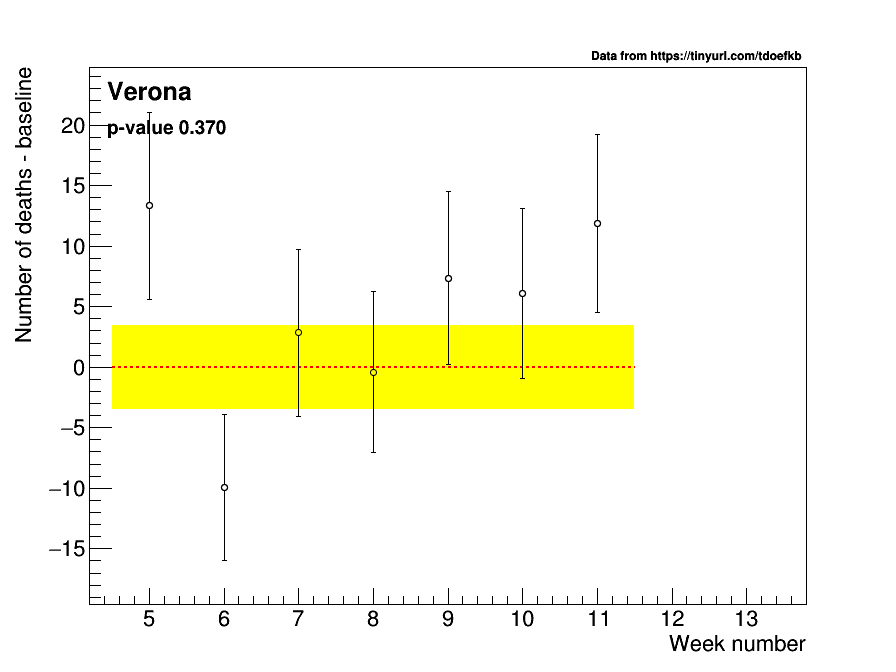

In [18]:

for p in provinces:
    graphs['eccesso_deceduti_%s'%p].Draw("APSAME")
    graphs['eccesso_deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['eccesso_deceduti_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")

    baseline_stdev=graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)
    box=R.TBox(4.5,-baseline_stdev,11.5,baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(4.5,0,11.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)
    line.Draw()

    graphs['eccesso_deceduti_%s'%p].Draw("PSAME")
    
    f0=R.TF1("f0","pol0",0,graphs['eccesso_deceduti_%s'%p].GetN()+6)
    graphs['eccesso_deceduti_%s'%p].Fit('f0','RB0Q','')
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    if (f0.GetProb()>=1E-3):
        t.DrawLatexNDC(0.12,0.8,'p-value %.3f'%f0.GetProb())
    else:
        t.DrawLatexNDC(0.12,0.8,'p-value < 0.001')

    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathExcess_{:s}".format(p)+ext)



Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Aosta.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Aosta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Aosta.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bari.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bari.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bari.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bologna.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bologna.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/death_B

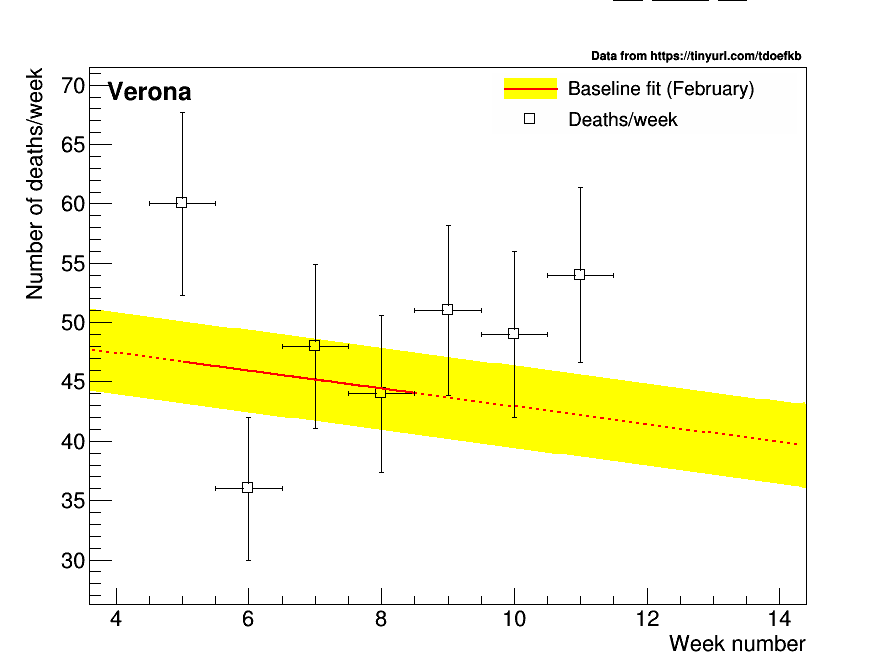

In [19]:
leg=R.TLegend(0.55,0.89,0.89,0.8)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)

for p in provinces:
    leg.Clear()
    graphs['deceduti_%s'%p].Draw("APSAME")
    graphs['deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['deceduti_%s'%p].GetYaxis().SetTitle("Number of deaths/week")
    
    f2=graphs['deceduti_%s'%p].GetFunction('fB').Clone()
    f2.SetRange(0,5.5+graphs['deceduti_%s'%p].GetN())
    f2.SetLineStyle(2)
    
    #make error band
    xA=graphs['deceduti_%s'%p].GetXaxis()
    xLow=xA.GetBinLowEdge(1)
    xHigh=xA.GetBinUpEdge(xA.GetNbins())
    xS = np.linspace(xLow, xHigh, 100)
    yS = [f2.Eval(x) for x in xS]
    xErr = np.zeros(100)
    yErr = [f2.GetParError(0) for x in xS]
    band=R.TGraphErrors(len(xS),xS,np.asarray(yS),xErr,np.asarray(yErr))
    band.SetFillColor(R.kYellow)
    
    band.Draw('4SAME')
    f2.Draw('LSAME')
    graphs['deceduti_%s'%p].Draw("PSAME")
    
    #auxiliary object for the legend
    aux=graphs['deceduti_%s'%p].Clone('aux')
    aux.SetFillColor(R.kYellow)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    #aux.SetFillStyle(3000)
    leg.AddEntry(aux,'Baseline fit (February)','FL')
    leg.AddEntry(graphs['deceduti_%s'%p],'Deaths/week','P')
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    leg.Draw()
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    c1.RedrawAxis()
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/death_{:s}".format(p)+ext)

Aosta
Bari
Bologna
Bolzano


<ipython-input-3-f3083f1045a0>:71: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)


Brescia
Firenze
Genova
Messina
Milano
Padova
Palermo
Perugia
Potenza
Roma
Torino
Trento
Venezia
Verona
 FCN=208.56 FROM MIGRAD    STATUS=CONVERGED      80 CALLS          81 TOTAL
                     EDM=8.45591e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -6.00949e+01   6.42426e-01   5.68268e-05  -1.14158e-03
   2  p1           1.00000e+00   5.06187e-03   4.49883e-04** at limit **
 FCN=284.516 FROM MIGRAD    STATUS=CONVERGED      81 CALLS          82 TOTAL
                     EDM=8.70563e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.62737e-01   9.77182e-01   8.03788e-05  -1.25250e-01
   2  p1           1.00000e+00   1.82614e-03   3.15385e-04** at limit **
 FCN

Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Aosta.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Aosta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Aosta.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Bari.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Bari.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Bari.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Bologna.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Bologna.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/merid

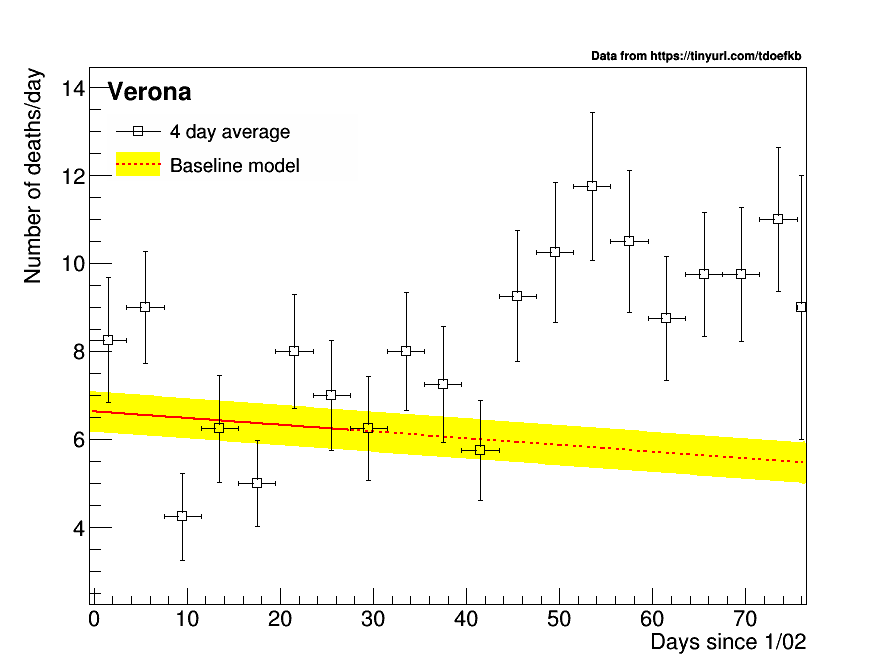

In [20]:
leg=R.TLegend(0.12,0.83,0.4,0.73)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)

for p in provincesDaily:
    leg.Clear()
    print(p)
    #graphs['eccesso_deceduti_giornalieri_%s'%p].Draw("APSAME")
    graphs['deceduti_giornalieri_%s'%p].GetXaxis().SetTitle("Days since 1/02")
    graphs['deceduti_giornalieri_%s'%p].GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['deceduti_giornalieri_%s'%p].GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['deceduti_giornalieri_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")
    graphs['deceduti_giornalieri_%s'%p].Fit('ff','RB+','',0,100)
    rebinned=rebinGraph(graphs['deceduti_giornalieri_%s'%p],4,1)
    rebinned.SetMarkerStyle(25)
    rebinned.SetMarkerSize(1.2)
    rebinned.Draw('AP')
    smoothed=smooth.SmoothSuper(rebinned,'')

    rebinned.GetXaxis().SetTitle("Days since 1/02")
    rebinned.GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetYaxis().SetTitle("Number of deaths/day")

    #baseline_stdev=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').GetParError(0)
    #box=R.TBox(-0.5,-baseline_stdev,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,baseline_stdev)
    #box.SetFillColor(R.kYellow)
    #box.Draw()
    #line=R.TLine(-0.5,0,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,0)
    #line.SetLineColor(R.kRed)
    #line.SetLineStyle(2)
    #line.SetLineWidth(2)
    #make error band
    xA=rebinned.GetXaxis()
    xLow=xA.GetBinLowEdge(1)
    xHigh=xA.GetBinUpEdge(xA.GetNbins())
    
    f2=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').Clone()
    f2.SetRange(xLow,xHigh)
    f2.SetLineStyle(2)
    
    xS = np.linspace(xLow, xHigh, 100)
    yS = [f2.Eval(x) for x in xS]
    xErr = np.zeros(100)
    yErr = [f2.GetParError(0) for x in xS]
    band=R.TGraphErrors(len(xS),xS,np.asarray(yS),xErr,np.asarray(yErr))
    band.SetFillColor(R.kYellow)
    
    band.Draw('4SAME')
    f2.Draw('LSAME')
    graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').Draw('LSAME')
    rebinned.Draw("PSAME")
    
    aux=R.TGraph()
    aux.SetFillColor(R.kYellow)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    aux.SetLineStyle(2)
    leg.AddEntry(rebinned,'4 day average','PL')
    leg.AddEntry(aux,'Baseline model','FL')
    leg.Draw()
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
                   
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    #ar=R.TArrow(29.5,rebinned.GetYaxis().GetBinLowEdge(1)+1,36,rebinned.GetYaxis().GetBinLowEdge(1)+1,0.02,"|>")
    #ar.Draw()
    #t.SetTextSize(0.03)
    #t.DrawLatex(29.5,rebinned.GetYaxis().GetBinLowEdge(1)+1.5,'March')
    
    c1.RedrawAxis()
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathDaily_{:s}".format(p)+ext)

------> Aosta
0.03356190697674419 0.03356190697674419
------> Bari
0.316658511627907 0.316658511627907


<ipython-input-3-f3083f1045a0>:71: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)
<ipython-input-3-f3083f1045a0>:122: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)


------> Bologna
0.3793352093023256 0.3793352093023256
------> Bolzano
0.10446376744186048 0.10446376744186048
------> Brescia
0.19209627906976745 0.19209627906976745
------> Firenze
0.3733682790697675 0.3733682790697675
------> Genova
0.5700288837209303 0.5700288837209303
------> Messina
0.2314512558139535 0.2314512558139535
------> Milano
1.3205581395348838 1.3205581395348838
------> Padova
0.2049492558139535 0.2049492558139535
------> Palermo
0.6580667441860465 0.6580667441860465
------> Perugia
0.1627998139534884 0.1627998139534884
------> Potenza
0.0656059534883721 0.0656059534883721
------> Roma
2.8061860465116277 2.8061860465116277
------> Torino
0.8662128837209303 0.8662128837209303
------> Trento
0.11468637209302325 0.11468637209302325
------> Venezia
0.2558141860465116 0.2558141860465116
------> Verona
0.9009322325581396 0.9009322325581396
 FCN=47.158 FROM MIGRAD    STATUS=CONVERGED     641 CALLS         642 TOTAL
                     EDM=3.76702e-08    STRATEGY= 1  ERROR MATR

Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Aosta.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Aosta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Aosta.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Bari.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Bari.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Bari.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Bologna.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Bologna.png has been created
I

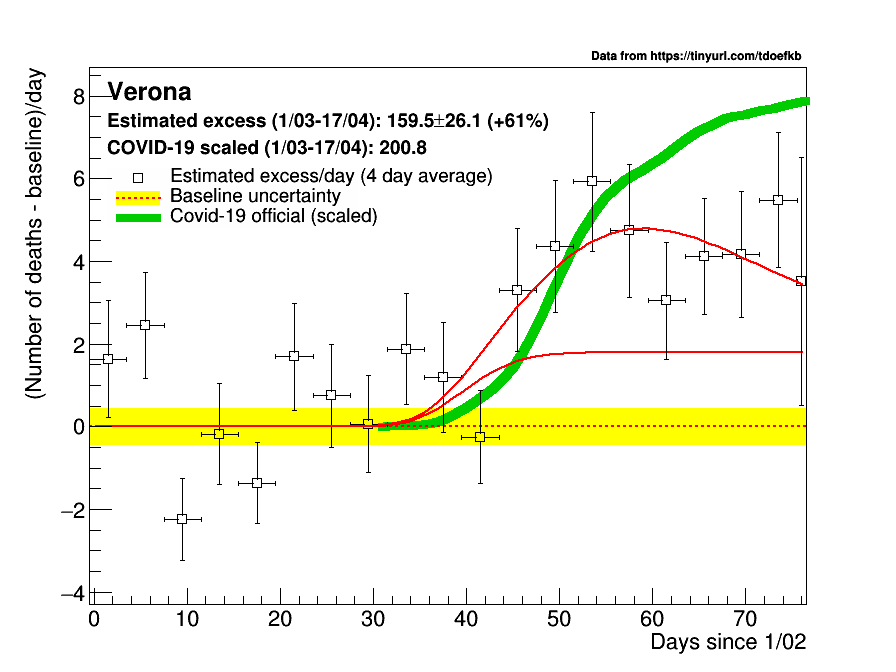

In [21]:
leg=R.TLegend(0.12,0.75,0.4,0.66)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)        
        
for p in provincesDaily:
    print('------> %s'%p)
    leg.Clear()
    #graphs['eccesso_deceduti_giornalieri_%s'%p].Draw("APSAME")
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetXaxis().SetTitle("Days since 1/02")
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")
    graphs['eccesso_deceduti_giornalieri_%s'%p].Fit('ff','RB+','',0,100)
    rebinned=rebinGraph(graphs['eccesso_deceduti_giornalieri_%s'%p],4,1)
    rebinned.SetMarkerStyle(25)
    rebinned.SetMarkerSize(1.2)
    rebinned.Draw('AP')
    smoothed=smooth1.SmoothKern(rebinned,'normal',10)
    smoothed.SetName('smoothed_rebin4')
    rebinned.GetXaxis().SetTitle("Days since 1/02")
    rebinned.GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetYaxis().SetTitle("(Number of deaths - baseline)/day")
  
    normalDeath=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').Integral(31,graphs['eccesso_deceduti_giornalieri_%s'%p].GetN()-1)
    totalExcess=integralGraph(graphs['eccesso_deceduti_giornalieri_%s'%p],31)
    expectedExcess=integralGraph(graphs['estimated_death_town_%s'%p],0,graphs['eccesso_deceduti_giornalieri_%s'%p].GetN()-31)
    if(expectedExcess[0]>0):
        ratio=totalExcess[0]/expectedExcess[0]
    else:
        ratio=0


    dgompertz.SetParameter(0,totalExcess[0]*2)
    dgompertz.SetParameter(2,0.1)
    dgompertz.SetParameter(1,4)
    dgompertz.SetParameter(3,45)
#    covidTotal.FixParameter(4,30./7/4.3E6*townPopulation[p]) #turn-on has plateau at 2 not at 1
    rebinned.Fit('dgompertz','RB0','')
    for i in range(4):
        covidTotal.SetParameter(i,dgompertz.GetParameter(i))
    covidTotal.FixParameter(4,4.2*(townPopulation[p]/4.3E6)) #turn-on has plateau at 2 not at 1, normalised @ ~60 deaths/week/4.3M 
    rebinned.Fit('covidTotal','RB+','')
    for i in range(4):
        dgompertz.SetParameter(i,covidTotal.GetParameter(i))
    for i in range(3):
        cdeaths.SetParameter(i,covidTotal.GetParameter(4+i))
    
    graphs['covidTotal_giornalieri_fit_%s'%p]=covidTotal.Clone('covidTotal_giornalieri_fit_%s'%p)
    graphs['cdeaths_giornalieri_fit_%s'%p]=cdeaths.Clone('cdeaths_giornalieri_fit_%s'%p)
    graphs['covid_giornalieri_fit_%s'%p]=dgompertz.Clone('covid_giornalieri_fit_%s'%p)
    
    print(4.2*(townPopulation[p]/4.3E6),covidTotal.GetParameter(4))

    baseline_stdev=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').GetParError(0)
    box=R.TBox(-0.5,-baseline_stdev,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(-0.5,0,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)

    #graphs['eccesso_deceduti_giornalieri_%s'%p].Draw("PSAME")
    smoothedExt=smooth.SmoothSuper(graphs['estimated_death_town_%s'%p],'')
    graphs['estimated_death_town_%s'%p].SetLineColor(R.kGreen+1)
    graphs['estimated_death_town_%s'%p].SetLineWidth(8)
    #graphs['estimated_death_town_%s'%p].Draw("LSAME")
    smoothedExt.SetLineColor(R.kGreen+1)
    smoothedExt.SetLineWidth(8)
    smoothedExt.Draw("LSAME")
    line.Draw()
    #f.Draw('LSAME')        
    f1=R.TF1('f1','[2]*TMath::Exp((x+[0])/[1])',0,100)
    f1.SetParameter(0,f.GetParameter(0))
    f1.SetParameter(1,f.GetParameter(1))
    f1.SetParameter(2,1/ratio)
    f1.SetLineColor(R.kRed)
    f1.SetLineStyle(2)
    f1.SetLineWidth(2)
    #f1.Draw('LSAME')

    smoothed.SetLineColor(R.kBlack+1)
    smoothed.SetLineWidth(2)
    #dgompertz.Draw('SAME')
    cdeaths.Draw('SAME')
    #smoothed.Draw("LSAME")
    rebinned.Draw("PSAME")
    
    aux=R.TGraph()
    aux.SetFillColor(R.kYellow)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    aux.SetLineStyle(2)
    leg.AddEntry(rebinned,'Estimated excess/day (4 day average)','P')
    leg.AddEntry(aux,'Baseline uncertainty','FL')
    leg.AddEntry(smoothedExt,'Covid-19 official (scaled)','L')
    leg.Draw()
    f0=R.TF1("f0","pol0",0,100)
    rebinned1=rebinGraph(graphs['eccesso_deceduti_giornalieri_%s'%p],4,1)
    rebinned1.Fit('f0','0Q+')
    prob=rebinned1.GetFunction('f0').GetProb()
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    #if (prob>=1E-3):
    #    t.DrawLatexNDC(0.12,0.8,'no excess p-value %.3f'%prob)
    #else:
    #    t.DrawLatexNDC(0.12,0.8,'no excess p-value < 0.001')

    totalExcessError=R.TMath.Sqrt(totalExcess[1]**2+(baseline_stdev*35)**2)
    if (normalDeath>0):
        t.DrawLatexNDC(0.12,0.81,'Estimated excess (1/03-17/04): %.1f#pm%.1f'%(totalExcess[0],totalExcessError)+' (+{:.0%})'.format(totalExcess[0]/normalDeath))
        t.DrawLatexNDC(0.12,0.77,'COVID-19 scaled (1/03-17/04): %.1f'%expectedExcess[0])
                   
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    #ar=R.TArrow(29.5,rebinned.GetYaxis().GetBinLowEdge(1)+1,36,rebinned.GetYaxis().GetBinLowEdge(1)+1,0.02,"|>")
    #ar.Draw()
    #t.SetTextSize(0.03)
    #t.DrawLatex(29.5,rebinned.GetYaxis().GetBinLowEdge(1)+1.5,'March')
    
    c1.RedrawAxis()
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathExcessDaily_{:s}".format(p)+ext)

------> Aosta
------> Bari
------> Bologna
------> Bolzano


<ipython-input-22-c0d7c8308a33>:7: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  graphs['covid19_deceduti_giornalieri_%s'%p].GetPoint(i,x,y)
<ipython-input-3-f3083f1045a0>:71: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)
<ipython-input-3-f3083f1045a0>:122: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)


------> Brescia
------> Firenze
------> Genova
------> Messina
------> Milano
------> Padova
------> Palermo
------> Perugia
------> Potenza
------> Roma
------> Torino
------> Trento
------> Venezia
------> Verona


Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/covid19ExcessDaily_Aosta.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/covid19ExcessDaily_Aosta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/covid19ExcessDaily_Aosta.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/covid19ExcessDaily_Bari.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/covid19ExcessDaily_Bari.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/covid19ExcessDaily_Bari.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/covid19ExcessDaily_Bologna.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/covid19ExcessDaily_Bologna.png ha

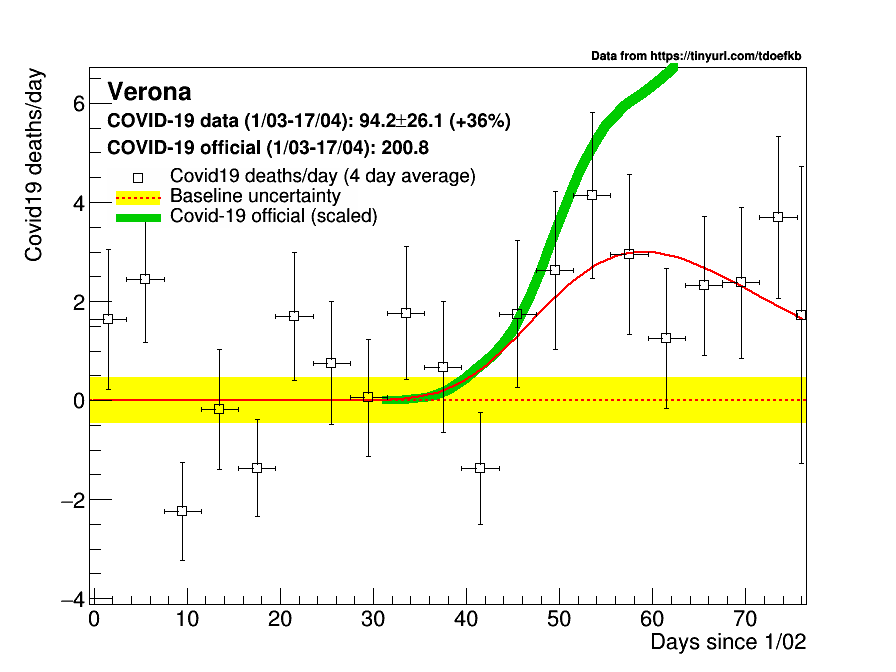

In [22]:
for p in provincesDaily:
    print('------> %s'%p)
    leg.Clear()
    graphs['covid19_deceduti_giornalieri_%s'%p]=graphs['eccesso_deceduti_giornalieri_%s'%p].Clone('covid19_deceduti_giornalieri_%s'%p)
    for i in range(graphs['covid19_deceduti_giornalieri_%s'%p].GetN()):
        x,y=R.Double(0),R.Double(0)
        graphs['covid19_deceduti_giornalieri_%s'%p].GetPoint(i,x,y)
        cd=graphs['cdeaths_giornalieri_fit_%s'%p].Eval(x)
        graphs['covid19_deceduti_giornalieri_%s'%p].SetPoint(i,x,y-cd)
    graphs['covid19_deceduti_giornalieri_%s'%p].GetXaxis().SetTitle("Days since 1/02")
    graphs['covid19_deceduti_giornalieri_%s'%p].GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['covid19_deceduti_giornalieri_%s'%p].GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['covid19_deceduti_giornalieri_%s'%p].GetYaxis().SetTitle("Number of COVID19 deaths/day")
#    graphs['covid19_deceduti_giornalieri_%s'%p].Fit('ff','RB+','',0,100)
    rebinned=rebinGraph(graphs['covid19_deceduti_giornalieri_%s'%p],4,1)
    rebinned.SetMarkerStyle(25)
    rebinned.SetMarkerSize(1.2)
    rebinned.Draw('AP')
    smoothed=smooth1.SmoothKern(rebinned,'normal',10)
    smoothed.SetName('smoothed_rebin4')
    rebinned.GetXaxis().SetTitle("Days since 1/02")
    rebinned.GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetYaxis().SetTitle("Covid19 deaths/day")
  
    normalDeath=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').Integral(31,graphs['covid19_deceduti_giornalieri_%s'%p].GetN()-1)
    totalExcess=integralGraph(graphs['covid19_deceduti_giornalieri_%s'%p],31)
    expectedExcess=integralGraph(graphs['estimated_death_town_%s'%p],0,graphs['covid19_deceduti_giornalieri_%s'%p].GetN()-31)
    if(expectedExcess[0]>0):
        ratio=totalExcess[0]/expectedExcess[0]
    else:
        ratio=0


    baseline_stdev=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').GetParError(0)
    box=R.TBox(-0.5,-baseline_stdev,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(-0.5,0,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)

    #graphs['covid19_deceduti_giornalieri_%s'%p].Draw("PSAME")
    smoothedExt=smooth.SmoothSuper(graphs['estimated_death_town_%s'%p],'')
    graphs['estimated_death_town_%s'%p].SetLineColor(R.kGreen+1)
    graphs['estimated_death_town_%s'%p].SetLineWidth(8)
    #graphs['estimated_death_town_%s'%p].Draw("LSAME")
    smoothedExt.SetLineColor(R.kGreen+1)
    smoothedExt.SetLineWidth(8)
    smoothedExt.Draw("LSAME")
    line.Draw()

    smoothed.SetLineColor(R.kBlack+1)
    smoothed.SetLineWidth(2)
    graphs['covid_giornalieri_fit_%s'%p].Draw('SAME')
    rebinned.Draw("PSAME")
    
    aux=R.TGraph()
    aux.SetFillColor(R.kYellow)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    aux.SetLineStyle(2)
    leg.AddEntry(rebinned,'Covid19 deaths/day (4 day average)','P')
    leg.AddEntry(aux,'Baseline uncertainty','FL')
    leg.AddEntry(smoothedExt,'Covid-19 official (scaled)','L')
    leg.Draw()
    
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    #if (prob>=1E-3):
    #    t.DrawLatexNDC(0.12,0.8,'no excess p-value %.3f'%prob)
    #else:
    #    t.DrawLatexNDC(0.12,0.8,'no excess p-value < 0.001')

    totalExcessError=R.TMath.Sqrt(totalExcess[1]**2+(baseline_stdev*35)**2)
    if (normalDeath>0):
        t.DrawLatexNDC(0.12,0.81,'COVID-19 data (1/03-17/04): %.1f#pm%.1f'%(totalExcess[0],totalExcessError)+' (+{:.0%})'.format(totalExcess[0]/normalDeath))
        t.DrawLatexNDC(0.12,0.77,'COVID-19 official (1/03-17/04): %.1f'%expectedExcess[0])
                   
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    #ar=R.TArrow(29.5,rebinned.GetYaxis().GetBinLowEdge(1)+1,36,rebinned.GetYaxis().GetBinLowEdge(1)+1,0.02,"|>")
    #ar.Draw()
    #t.SetTextSize(0.03)
    #t.DrawLatex(29.5,rebinned.GetYaxis().GetBinLowEdge(1)+1.5,'March')
    
    c1.RedrawAxis()
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/covid19ExcessDaily_{:s}".format(p)+ext)

In [80]:
groups={}
groups['nord']=['Torino','Milano','Genova','Brescia','Aosta','Firenze','Bologna']
groups['centrosud']=['Roma','Bari','Palermo','Messina','Potenza','Perugia']
groupPopulation={}
fB=R.TF1('fB','[0]*(1-0.0023*x)',0,100)
fB.SetParameter(0,100)
for g in groups.keys():
    groupPopulation[g]=0
    for p in groups[g]:
        groupPopulation[g]+=townPopulation[p]
    graphs['deceduti_giornalieri_%s'%g]=addGraphs([ graphs['deceduti_giornalieri_%s'%p] for p in groups[g]]).Clone('deceduti_giornalieri_%s'%g)
    graphs['deceduti_giornalieri_%s'%g].Fit('fB','RB+','',0,27.5)
    graphs['eccesso_deceduti_giornalieri_%s'%g]=addGraphs([ graphs['eccesso_deceduti_giornalieri_%s'%p] for p in groups[g]]).Clone('eccesso_deceduti_giornalieri_%s'%g)
    graphs['estimated_death_town_%s'%g]=addGraphs([ graphs['estimated_death_town_%s'%p] for p in groups[g]]).Clone('estimated_death_town_%s'%g)
    graphs['covid19_deceduti_giornalieri_%s'%g]=addGraphs([ graphs['covid19_deceduti_giornalieri_%s'%p] for p in groups[g]]).Clone('covid19_deceduti_giornalieri_%s'%g)
    graphs['covidTotal_giornalieri_fit_%s'%g]=addFunctions([ graphs['covidTotal_giornalieri_fit_%s'%p] for p in groups[g]],0,100).Clone('covidTotal_giornalieri_fit_%s'%g)
    graphs['cdeaths_giornalieri_fit_%s'%g]=addFunctions([ graphs['cdeaths_giornalieri_fit_%s'%p] for p in groups[g]],-1,100).Clone('cdeaths_giornalieri_fit_%s'%g)
    graphs['covid_giornalieri_fit_%s'%g]=addFunctions([ graphs['covid_giornalieri_fit_%s'%p] for p in groups[g]],0,100).Clone('covid_giornalieri_fit_%s'%g)

<ipython-input-74-45be42f5f186>:44: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  graphs[0].GetPoint(i,x1,y1)
<ipython-input-74-45be42f5f186>:53: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g1.GetPoint(i,x1,y1)
<ipython-input-74-45be42f5f186>:55: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)
<ipython-input-74-45be42f5f186>:71: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(ix,x,y)


 FCN=19.7602 FROM MIGRAD    STATUS=CONVERGED      12 CALLS          13 TOTAL
                     EDM=7.96557e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.10548e+02   2.01874e+00   4.49105e-03  -1.97717e-04
 FCN=15.3016 FROM MIGRAD    STATUS=CONVERGED      12 CALLS          13 TOTAL
                     EDM=4.58239e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.13330e+02   2.04398e+00   4.02954e-03  -1.48110e-05


------> nord
------> centrosud


<ipython-input-74-45be42f5f186>:89: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)
<ipython-input-74-45be42f5f186>:140: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  g.GetPoint(i,x,y)
<ipython-input-74-45be42f5f186>:10: FutureWarning: ROOT.Double is deprecated and will disappear in a future version of ROOT. Instead, use ctypes.c_double for pass-by-ref of doubles
  graph.GetPoint(i,x,y)
Warning in <TROOT::Append>: Replacing existing TH1: cdeaths_giornalieri_fit_nord_histo (Potential memory leak).
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessGroupDaily_nord.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessGroupDaily_nord.png has been created
Info in <TCanvas::SaveAs

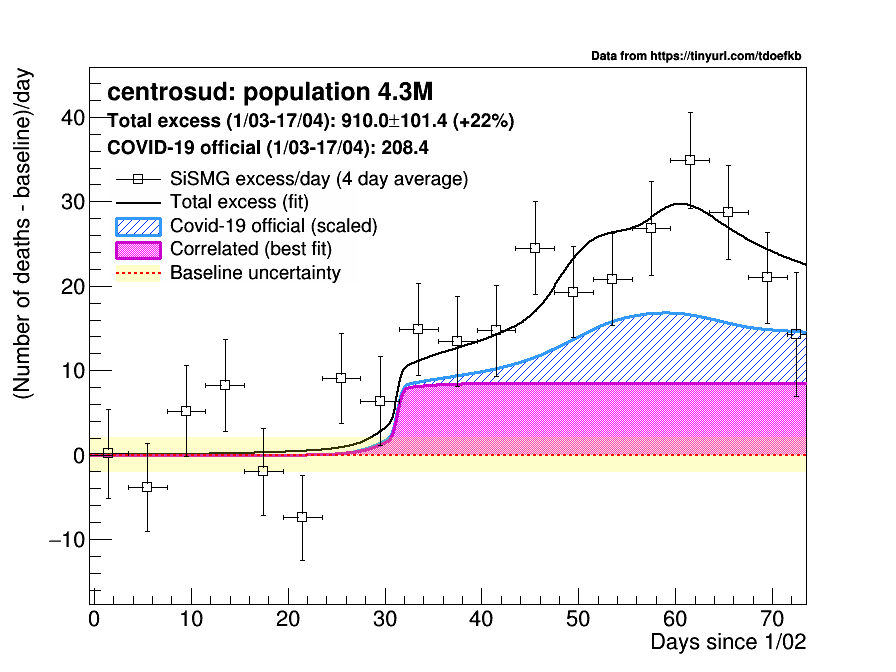

In [101]:
leg=R.TLegend(0.12,0.75,0.4,0.575)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)    

for p in groups.keys():
    print('------> %s'%p)
    leg.Clear()
    #graphs['eccesso_deceduti_giornalieri_%s'%p].Draw("APSAME")
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetXaxis().SetTitle("Days since 1/02")
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")
    rebinned=rebinGraph(graphs['eccesso_deceduti_giornalieri_%s'%p],4,1)
    rebinned.SetMarkerStyle(25)
    rebinned.SetMarkerSize(1.2)
    rebinned.Draw('AP')
    smoothed=smooth1.SmoothKern(rebinned,'normal',10)
    smoothed.SetName('smoothed_rebin4')
    rebinned.GetXaxis().SetTitle("Days since 1/02")
    rebinned.GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetYaxis().SetTitle("(Number of deaths - baseline)/day")
  
    normalDeath=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').Integral(31,graphs['eccesso_deceduti_giornalieri_%s'%p].GetN()-1)
    totalExcess=integralGraph(graphs['eccesso_deceduti_giornalieri_%s'%p],31)
    expectedExcess=integralGraph(graphs['estimated_death_town_%s'%p],0,graphs['eccesso_deceduti_giornalieri_%s'%p].GetN()-31)
    if(expectedExcess[0]>0):
        ratio=totalExcess[0]/expectedExcess[0]
    else:
        ratio=0

    baseline_stdev=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').GetParError(0)
    box=R.TBox(-0.5,-baseline_stdev,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,baseline_stdev)
    box.SetFillColorAlpha(R.kYellow,0.20)
    
    line=R.TLine(-0.5,0,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)


    line.Draw()
    
    #graphs['eccesso_deceduti_giornalieri_%s'%p].Draw("PSAME")
    smoothedExt=smooth.SmoothKern(graphs['estimated_death_town_%s'%p],'normal',10)
    graphs['estimated_death_town_%s'%p].SetLineColor(R.kGreen+1)
    graphs['estimated_death_town_%s'%p].SetLineWidth(8)
    #graphs['estimated_death_town_%s'%p].Draw("LSAME")
    smoothedExt.SetLineColor(R.kGreen+1)
    smoothedExt.SetLineWidth(8)
    #smoothedExt.Draw("LSAME")

    smoothed.SetLineColor(R.kBlack+1)
    smoothed.SetLineWidth(2)
    
    h1=getHisto(graphs['cdeaths_giornalieri_fit_%s'%p])
    h1.SetFillStyle(3001)
    h1.SetFillColor(R.kMagenta)
    h1.SetLineWidth(3)
    h1.SetLineColor(R.kMagenta+1)
    h2=getInterpolatedHisto(smoothedExt,h1).Clone('estimated_death_town_%s_histo'%p)
    h2.SetFillStyle(3004)
    h2.SetFillColor(R.kAzure)
    h2.SetLineWidth(3)
    h2.SetLineColor(R.kAzure+1)
    
    graphs['categorised_giornalieri_fit_%s'%p]=R.THStack('categorised_giornalieri_fit_%s'%p,'')
    graphs['categorised_giornalieri_fit_%s'%p].Add(h1)
    graphs['categorised_giornalieri_fit_%s'%p].Add(h2)
    #smoothed.Draw("LSAME")
    graphs['covidTotal_giornalieri_fit_%s'%p].SetLineWidth(2)
    graphs['covidTotal_giornalieri_fit_%s'%p].SetLineColor(R.kBlack)
    graphs['covidTotal_giornalieri_fit_%s'%p].Draw('CSAME')
    #graphs['cdeaths_giornalieri_fit_%s'%p].SetLineColor(R.kBlue)
    #graphs['cdeaths_giornalieri_fit_%s'%p].Draw('CSAME')
    graphs['categorised_giornalieri_fit_%s'%p].Draw('SAME')
    box.Draw()
    line.Draw()
    rebinned.Draw("PSAME")
    
    
    aux=R.TGraph()
    aux.SetFillColorAlpha(R.kYellow,0.2)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    aux.SetLineStyle(2)
    leg.AddEntry(rebinned,'SiSMG excess/day (4 day average)','PL')
    leg.AddEntry(graphs['covidTotal_giornalieri_fit_%s'%p],'Total excess (fit)','L')
    leg.AddEntry(h2,'Covid-19 official (scaled)','F')
    leg.AddEntry(h1,'Correlated (best fit)','F')
    leg.AddEntry(aux,'Baseline uncertainty','FL')
    leg.Draw()

    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,'%s: population %2.1fM'%(p,groupPopulation[p]/1E6))
    t.SetTextSize(0.03)

    totalExcessError=R.TMath.Sqrt(totalExcess[1]**2+(baseline_stdev*35)**2)
    if (normalDeath>0):
        t.DrawLatexNDC(0.12,0.81,'Total excess (1/03-17/04): %.1f#pm%.1f'%(totalExcess[0],totalExcessError)+' (+{:.0%})'.format(totalExcess[0]/normalDeath))
        t.DrawLatexNDC(0.12,0.77,'COVID-19 official (1/03-17/04): %.1f'%expectedExcess[0])
                   
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    #ar=R.TArrow(29.5,rebinned.GetYaxis().GetBinLowEdge(1)+1,36,rebinned.GetYaxis().GetBinLowEdge(1)+1,0.02,"|>")
    #ar.Draw()
    #t.SetTextSize(0.03)
    #t.DrawLatex(29.5,rebinned.GetYaxis().GetBinLowEdge(1)+1.5,'March')
    
    c1.RedrawAxis()
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathExcessGroupDaily_{:s}".format(p)+ext)

In [25]:
dfIstat.head()

,REG,PROV,COD_PROVCOM,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,DATA_INIZIO_DIFF,SETTIMANA,CLASSE_DI_ETA,MASCHI_2015,...,FEMMINE_2017,FEMMINE_2018,FEMMINE_2019,FEMMINE_2020,TOTALE_2015,TOTALE_2016,TOTALE_2017,TOTALE_2018,TOTALE_2019,TOTALE_2020
0,1,1,1001,Piemonte,Torino,Agliè,1 aprile,01/01-11/01,0-14 anni,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1001,Piemonte,Torino,Agliè,1 aprile,12/01-18/01,0-14 anni,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1001,Piemonte,Torino,Agliè,1 aprile,19/01-25/01,0-14 anni,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1001,Piemonte,Torino,Agliè,1 aprile,26/01-01/02,0-14 anni,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1001,Piemonte,Torino,Agliè,1 aprile,02/02-08/02,0-14 anni,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
regions = n.unique(dfIstat['NOME_REGIONE'])
#weeks=n.unique(dfIstat['SETTIMANA'])
weeks={'01/01-11/01':0 , '01/03-07/03':8, '02/02-08/02':4, '08/03-14/03':9, '09/02-15/02':5,
 '12/01-18/01':1, '15/03-21/03':10, '16/02-22/02':6, '19/01-25/01':2, '23/02-29/02':7,
 '26/01-01/02':3}
ages=n.unique(dfIstat['CLASSE_DI_ETA'])
print(ages)
for w,index in weeks.items():
#    print(index,w)
    dfIstat=dfIstat.replace(w,index)

for a in ages:
    age=a
    index=int(n.where(ages == a)[0])
#    print(index,age)
    dfIstat=dfIstat.replace(age,index)
    
dfIstat.head()

NameError: name 'n' is not defined

In [ ]:
dfDeaths={}
for p in regions:
    print('=======',p)
    dfDeaths[p]=dfIstat[dfIstat['NOME_REGIONE']==p]
    for w in range(len(weeks)):
            print(p,w,dfDeaths[p].loc[dfDeaths[p]['SETTIMANA']==w]['TOTALE_2020'].sum())
        
#    dfDaily[p]=dfDaily[p].drop(columns=['Town'])
#    dfDaily[p]=dfDaily[p].transpose()
#    dfDaily[p].columns=['number_of_deaths']
#    dfDaily[p]['number_of_deaths']=dfDaily[p]['number_of_deaths'].astype(float)

In [ ]:
dfByTownAgeWeekly.head()

In [ ]:
dfByAge={}

provinces = n.unique(dfByTownAgeWeekly['citta'])
for p in provinces:
    dfByAge[p]=dfByTownAgeWeekly[dfByTownAgeWeekly['citta']==p]
    dfByAge[p]=dfByAge[p].drop(columns=['citta'])
    #dfByAge[p]=dfByAge[p].transpose()
    #dfByAge[p].columns=['number_of_deaths']
    dfByAge[p]=dfByAge[p].set_index('settimana')
    dfByAge[p].columns=['All','65m74','74m85','85p']
    print(p,len(dfByAge[p]))

In [ ]:
dfByAge['MILANO'].head()

In [ ]:
for p in provinces:
    for c in dfByAge[p].columns:
        graphs['deceduti_%s_%s'%(p,c)]=R.TGraphErrors()
        graphs['deceduti_%s_%s'%(p,c)].SetName('deceduti_%s_%s'%(p,c))
                                    
        for i,ni in enumerate(dfByAge[p][c]):
            #print(i,ni)
            scale=1.
            graphs['deceduti_%s_%s'%(p,c)].SetPoint(i,i+5,ni*scale)
            graphs['deceduti_%s_%s'%(p,c)].SetPointError(i,0.5,R.TMath.Sqrt(ni)*scale)
        graphs['deceduti_%s_%s'%(p,c)].SetLineColor(R.kBlack)
        graphs['deceduti_%s_%s'%(p,c)].SetMarkerColor(R.kBlack)
        graphs['deceduti_%s_%s'%(p,c)].SetMarkerStyle(25)
        graphs['deceduti_%s_%s'%(p,c)].SetMarkerSize(1.3)
        #Temporary: using as baseline fit of February data
        fB=R.TF1('fB','[0]*(1-0.0023*7*(x-5))',0,100)
        graphs['deceduti_%s_%s'%(p,c)].Fit('fB','RQB+','',5,8.5)

        graphs['eccesso_deceduti_%s_%s'%(p,c)]=R.TGraphErrors()
        graphs['eccesso_deceduti_%s_%s'%(p,c)].SetName('eccesso_deceduti_%s_%s'%(p,c))
        for i,ni in enumerate(dfByAge[p][c]):
            scale=1.
            #if (i==len(dfByAge[p][c])-1):
            #    scale=7./lastWeekDays[p]
            graphs['eccesso_deceduti_%s_%s'%(p,c)].SetPoint(i,i+5,ni*scale-graphs['deceduti_%s_%s'%(p,c)].GetFunction('fB').Eval(i+5))
            graphs['eccesso_deceduti_%s_%s'%(p,c)].SetPointError(i,0,R.TMath.Sqrt(ni)*scale)
        graphs['eccesso_deceduti_%s_%s'%(p,c)].SetLineColor(R.kBlack)
        graphs['eccesso_deceduti_%s_%s'%(p,c)].SetMarkerColor(R.kBlack)
        graphs['eccesso_deceduti_%s_%s'%(p,c)].SetMarkerStyle(24)
        graphs['eccesso_deceduti_%s_%s'%(p,c)].SetMarkerSize(0.9)

In [ ]:
R.gStyle.SetOptTitle(0)

for p in provinces:
    graphs['fractionOfExcess_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_byAge_%s'%p]=R.TGraphErrors()
    totalExcess={}
    for c in dfByAge[p].columns:
        graphs['eccesso_deceduti_%s_%s'%(p,c)].Draw("APSAME")
        graphs['eccesso_deceduti_%s_%s'%(p,c)].GetXaxis().SetTitle("Week number")
        graphs['eccesso_deceduti_%s_%s'%(p,c)].GetYaxis().SetTitle("Number of deaths - baseline")

        baseline_stdev=graphs['deceduti_%s_%s'%(p,c)].GetFunction('fB').GetParError(0)
        box=R.TBox(4.5,-baseline_stdev,11.5,baseline_stdev)
        box.SetFillColor(R.kYellow)
        box.Draw()
        line=R.TLine(4.5,0,11.5,0)
        line.SetLineColor(R.kRed)
        line.SetLineStyle(2)
        line.SetLineWidth(2)
        line.Draw()

        graphs['eccesso_deceduti_%s_%s'%(p,c)].Draw("PSAME")
    
        f0=R.TF1("f0","pol0",0,graphs['eccesso_deceduti_%s_%s'%(p,c)].GetN()+6)
        graphs['eccesso_deceduti_%s_%s'%(p,c)].Fit('f0','RB0Q','')
        t.SetTextSize(0.04)
        t.DrawLatexNDC(0.12,0.85,p)
        t.SetTextSize(0.03)
        if (f0.GetProb()>=1E-3):
            t.DrawLatexNDC(0.12,0.8,'p-value %.3f'%f0.GetProb())
        else:
            t.DrawLatexNDC(0.12,0.8,'p-value < 0.001')

        totalExcess[c]=integralGraph(graphs['eccesso_deceduti_%s_%s'%(p,c)],4)
        t.DrawLatexNDC(0.12,0.76,'Estimated excess (1-20/03): %.1f#pm%.1f'%(totalExcess[c][0],totalExcess[c][1]))
        
        t.SetTextSize(0.02)
        t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
        
        c1.Draw()
        for ext in ['.pdf','.png','.root']:
            c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathExcess_{:s}_{:s}".format(p,c)+ext)

    ip=0
    for ic,c in enumerate(dfByAge[p].columns):
        
        if (c=='All'):
            continue
        frac=totalExcess[c][0]/totalExcess['All'][0]
        #print(ip)
        graphs['fractionOfExcess_%s'%p].SetPoint(ip,ip+1,frac)
        graphs['fractionOfExcess_%s'%p].SetPointError(ip,0.5,R.TMath.Sqrt(frac*(1-frac)/totalExcess['All'][0]))
        graphs['eccesso_deceduti_byAge_%s'%p].SetPoint(ip,ip+1,totalExcess[c][0])
        graphs['eccesso_deceduti_byAge_%s'%p].SetPointError(ip,0.5,totalExcess[c][1])
        ip+=1
    
    xLabels=['65-74','74-85','>85']   
    graphs['fractionOfExcess_%s'%p].SetMarkerStyle(24)
    graphs['fractionOfExcess_%s'%p].SetMarkerSize(1.2)
 
    
    a=R.TH2F('a','a',graphs['fractionOfExcess_%s'%p].GetN(),0.5,graphs['fractionOfExcess_%s'%p].GetN()+0.5,10,0,1.)
    a.GetYaxis().SetTitle('Deceased excess fraction')
    for ic,c in enumerate(dfByAge[p].columns):
        if (c=='All'):
            continue
        a.GetXaxis().SetBinLabel(ic,xLabels[ic-1]) 
    a.GetXaxis().SetLabelSize(0.05)
    a.GetXaxis().SetTitle('Age')
    a.SetStats(0)
    a.Draw()
    graphs['fractionOfExcess_%s'%p].Draw('PSAME')
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.78,'Estimated total excess (1-20/03): %.1f#pm%.1f'%(totalExcess[c][0],totalExcess[c][1]))    
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathFractionExcessByAge_{:s}".format(p)+ext)
 
    graphs['eccesso_deceduti_byAge_%s'%p].SetMarkerStyle(24)
    graphs['eccesso_deceduti_byAge_%s'%p].SetMarkerSize(1.2)
    graphs['eccesso_deceduti_byAge_%s'%p].GetYaxis().SetTitle('Dececeased excess')
    #graphs['eccesso_deceduti_byAge_%s'%p]].GetYaxis().SetLimits(0,0.7)
    #graphs['eccesso_deceduti_byAge_%s'%p]].GetYaxis().SetRangeUser(0,0.7)
    graphs['eccesso_deceduti_byAge_%s'%p].Draw('AP')
    
    yA=graphs['eccesso_deceduti_byAge_%s'%p].GetYaxis()
    yLow=yA.GetBinLowEdge(1)
    yHigh=yA.GetBinUpEdge(yA.GetNbins())
    
    a=R.TH2F('a','a',graphs['fractionOfExcess_%s'%p].GetN(),0.5,graphs['fractionOfExcess_%s'%p].GetN()+0.5,10,yLow,yHigh)
    a.GetYaxis().SetTitle('Deceased excess')
    for ic,c in enumerate(dfByAge[p].columns):
        if (c=='All'):
            continue
        a.GetXaxis().SetBinLabel(ic,xLabels[ic-1]) 
    a.GetXaxis().SetLabelSize(0.05)
    a.GetXaxis().SetTitle('Age')
    a.SetStats(0)
    a.Draw()
    graphs['eccesso_deceduti_byAge_%s'%p].Draw('PSAME')
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.78,'Estimated total excess (1-20/03): %.1f#pm%.1f'%(totalExcess['All'][0],totalExcess['All'][1]))    
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathExcessByAge_{:s}".format(p)+ext)

In [ ]:
fOut=R.TFile('~/cernbox/www/plots/COVID19_DA/graphs.root','RECREATE')
for o,g in graphs.items():
    g.Write()
fOut.Write()
fOut.Close()